# Sentiment + LSTM Model

The objective of this notebook is to forecast the closing price of Nvidia (NVDA) stock by integrating both market sentiment and historical price data.  

Sentiment scores were generated from Stocktwits messages mentioning Nvidia using a pre-trained transformer model (Twitter RoBERTa-base). These scores aim to capture the crowd psychology around Nvidia.

Additionally, the model incorporates **lag features** based on historical closing prices. These features help the model learn temporal dependencies and trends from past values.

The combined dataset—comprising sentiment scores and engineered lag features—is then used to train a **Long Short-Term Memory (LSTM)** neural network, a type of recurrent neural network well-suited for time series forecasting.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as t
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [4]:
# reading in the nvidia closing price and daily tweet summary
nvidia_closing = pd.read_csv('./datasets/nvidiaClosingPrice.csv')
daily_summary = pd.read_csv('./datasets/dailyTweetSummary.csv')


# clean up header misalignment in nvidia_closing and remove rows where Date is NaN or not a date
nvidia_closing = clean_df[pd.to_datetime(nvidia_closing['Date'], errors='coerce').notna()]

# standardise date formats
nvidia_closing['Date'] = pd.to_datetime(nvidia_closing['Date']).dt.date
daily_summary['date'] = pd.to_datetime(daily_summary['date']).dt.date

# keep only dates present in nvidia_closing
daily_filtered = daily_summary[daily_summary['date'].isin(nvidia_closing['Date'].unique())]

# merge the datasets
merged_df = pd.merge(nvidia_closing, daily_filtered, left_on='Date', right_on='date', how='left')

# drop the duplicate 'date' column
merged_df = merged_df.drop(columns=['date'])

# save into a csv
merged_path = './datasets/merged.csv'
merged_df.to_csv(merged_path, index=False)

# check the head of the frame
merged_df.head()



,Date,Close,mean,count
0,2014-01-02,0.3739318549633026,-0.117343,7.0
1,2014-01-03,0.36945220828056335,0.000000,3.0
2,2014-01-06,0.37440332770347595,0.102030,20.0
3,2014-01-07,0.380533367395401,-0.054867,9.0
4,2014-01-08,0.38572031259536743,0.219977,13.0


In [14]:
# set df to the merge frame
df = merged_df[['Close', 'mean']]

# reset the index
clean_df = df.reset_index()

# check the head of the frame
clean_df.head()

,index,Close,mean
0,0,0.3739318549633026,-0.117343
1,1,0.36945220828056335,0.000000
2,2,0.37440332770347595,0.102030
3,3,0.380533367395401,-0.054867
4,4,0.38572031259536743,0.219977


In [15]:
clean_df = clean_df.copy()

# create lag features for past 3 days' closing prices
clean_df.loc[:, 'Close_lag1'] = clean_df['Close'].shift(1)
clean_df.loc[:, 'Close_lag2'] = clean_df['Close'].shift(2)
clean_df.loc[:, 'Close_lag3'] = clean_df['Close'].shift(3)

# create lag feature for the past 3 day's sentiment
clean_df.loc[:, 'Sent_lag1']  = clean_df['mean'].shift(1)
clean_df.loc[:, 'Sent_lag2']  = clean_df['mean'].shift(2)
clean_df.loc[:, 'Sent_lag3']  = clean_df['mean'].shift(3)

# drop any na created from the shift
clean_df = clean_df.dropna()

# reorder columns
clean_df = clean_df[
    ['Close_lag3', 'Sent_lag3',
     'Close_lag2', 'Sent_lag2',
     'Close_lag1', 'Sent_lag1',
     'Close']
    ]

# select features and label variable
features = [
    'Close_lag3', 'Sent_lag3',
    'Close_lag2', 'Sent_lag2',
    'Close_lag1', 'Sent_lag1'
    ]
target = 'Close'

# prepare X (features) and y (label)
X = clean_df[features].values
y = clean_df[target].values

# check the head of the frame
print(clean_df.head())

            Close_lag3  Sent_lag3           Close_lag2  Sent_lag2  \
3   0.3739318549633026  -0.117343  0.36945220828056335   0.000000   
4  0.36945220828056335   0.000000  0.37440332770347595   0.102030   
5  0.37440332770347595   0.102030    0.380533367395401  -0.054867   
6    0.380533367395401  -0.054867  0.38572031259536743   0.219977   
7  0.38572031259536743   0.219977   0.3713383376598358   0.246258   

            Close_lag1  Sent_lag1                Close  
3  0.37440332770347595   0.102030    0.380533367395401  
4    0.380533367395401  -0.054867  0.38572031259536743  
5  0.38572031259536743   0.219977   0.3713383376598358  
6   0.3713383376598358   0.246258   0.3708667755126953  
7   0.3708667755126953   0.076625   0.3621434271335602  


In [16]:

# converting dataframe to numpy array
df_as_np = clean_df.to_numpy()

# extracting dates
dates = np.array(clean_df.index)

# extract all columns excepting last one
middle_matrix = df_as_np[:, 0:-1]

# reshaping matrix to fit into a LSTM
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)).astype(str)
X = X.astype(np.float32)

# targets
Y = df_as_np[:, -1].astype(str)
y = Y.astype(np.float32)

#double-check shapes
dates.shape, X.shape, y.shape

((1937,), (1937, 6, 1), (1937,))

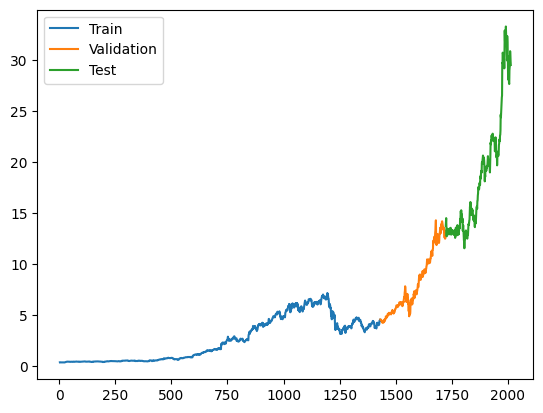

In [17]:
# split into training data and remaining val/test data
dates_train, dates_rem, X_train, X_rem, y_train, y_rem = train_test_split(
    dates, X, y, train_size=0.7, random_state=42, shuffle=False)

# split second half into validation and test
dates_val, dates_test, X_val, X_test, y_val, y_test = train_test_split(
    dates_rem, X_rem, y_rem, test_size=0.5, random_state=42, shuffle=False)

# plotting the test, train, and val set
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [18]:
# creating LSTM
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(128),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# defining the loss function and optimizer with Adam
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['mean_absolute_error'])

# training the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25)
print(model.summary)

Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 8.0681 - mean_absolute_error: 2.1201 - val_loss: 8.7247 - val_mean_absolute_error: 2.0443
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3400 - mean_absolute_error: 0.4692 - val_loss: 8.9551 - val_mean_absolute_error: 2.0905
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0808 - mean_absolute_error: 0.1967 - val_loss: 6.3036 - val_mean_absolute_error: 1.6497
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0647 - mean_absolute_error: 0.1775 - val_loss: 5.4897 - val_mean_absolute_error: 1.5160
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0607 - mean_absolute_error: 0.1737 - val_loss: 5.0499 - val_mean_absolute_error: 1.4473
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0623 - mean_absolute_error: 0.1722 - val_loss: 5.3490 - val_mean_absolute_error: 1.5290
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0579 - mean_absolute_error: 0.1693 - val_loss

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


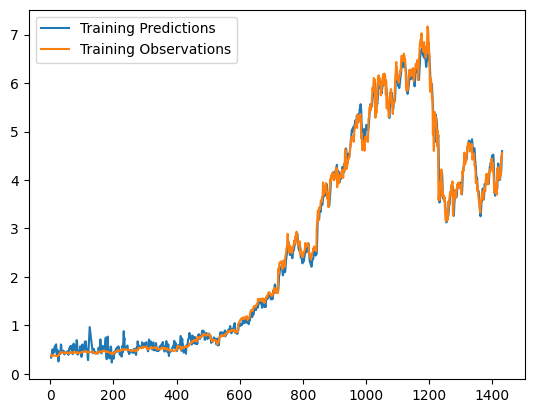

In [19]:
# seeing how our model performed on training data
train_predictions = model.predict(X_train)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


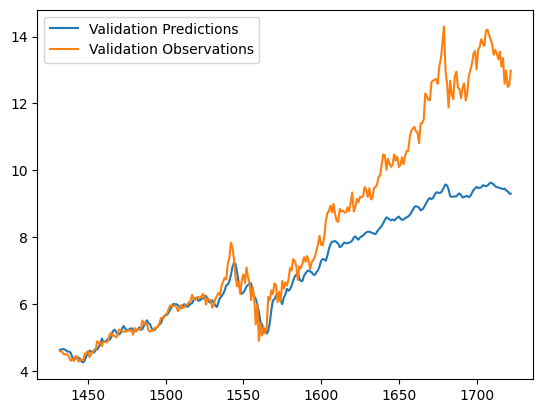

In [20]:
# seeing how our model performed on validation data
val_predictions = model.predict(X_val)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


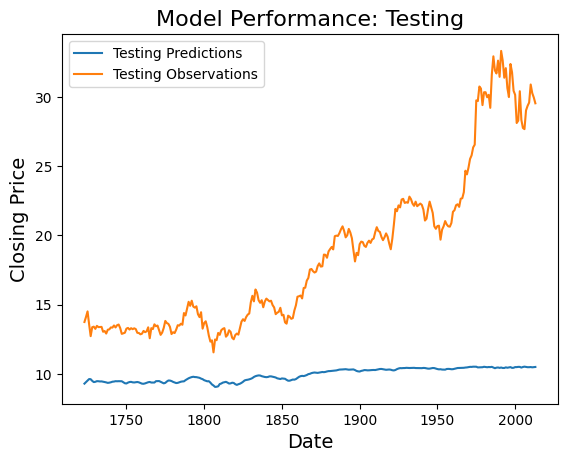

In [21]:
# seeing how our model performed on test data
test_predictions = model.predict(X_test)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Model Performance: Testing', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend(['Testing Predictions', 'Testing Observations'])

# further evaulations
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")